# Inicialización

Instalación de Spark y Java:


In [1]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

Configuración de las variables de entorno:

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

Conexión con Google Drive:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Rutas de inputs y outputs:

In [4]:
input_path = '/content/drive/MyDrive/Máster/APBD/Entregable_Spark/data/{}'
output_path= '/content/drive/MyDrive/Máster/APBD/Entregable_Spark/output/{}'
path_entregable = "/content/drive/MyDrive/Máster/APBD/Entregable_Spark/{}"

Ejecutamos Spark:

In [5]:
import findspark
findspark.init()

# Inicializamos la conexión con el motor de ejecución de Spark:
from pyspark.sql import SparkSession
# también tenemos una api de pandas para trabajar con tablas
spark = SparkSession.builder.master("local[*]").appName("nb03") \
    .getOrCreate()
sc = spark.sparkContext

Carga de librerias:

In [6]:
# local
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import inf as infinity

# Spark
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler # Para pipeline
from pyspark.ml.feature import PCA # Principal Component Analysis
from pyspark.sql.types import IntegerType # cambiar dtype de columna
import pyspark.sql.functions as F # Funciones útiles sql
import pyspark.ml.stat as stat # Correlaciones
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator # evaluar R^2, RMSE y MAE en regresión

Función de medida del rendimiento de los modelos de regresión:

In [7]:
execfile(path_entregable.format("rmsle.py"))

def eval_rendimiento(pred, target="SalePrice", pred_col="prediction",
                     metricas=["rmse", "mae", "r2", "rmsle"], print_values=True):
  res = {}
  for m in metricas:
    if m != "rmsle":
      # RMSE, MAE y R^2
      evaluador = RegressionEvaluator(labelCol=target, predictionCol=pred_col, metricName=m)
      res[m] = evaluador.evaluate(pred)
    else:
      # RMSLE (medida de Kaggle)
      res[m] = RmsleEvaluator(targetCol=target, predictionCol=pred_col).evaluate(pred)

    # En general se muestran los valores
    if print_values:
      print(f"{m} = {round(res[m], 5)}")

  return res


# Preprocesamiento de datos


## Carga de datos

Vamos a empezar trabajando con "train.csv", ya que "test.csv" no contiene la columna de la variable objetivo (SalePrice).

In [8]:
path = input_path.format("train.csv")
df = spark.read.csv(path, header=True, inferSchema=True)
df.show(3)

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

## Estudio de las variables

In [9]:
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

+ No necesitamos id.

+ MSSubClass es categórica, aunque usa números como clases.

+ Variables que contienen NAs que no significan valores faltantes: Alley, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature.

+ YearBuilt, YearRemodAdd: son años, así que vamos a tratarlas como variables numéricas.

+ Hay bastantes variables numéricas que aparecen con string. Esto podría deberse a la manera en la que se han introducido los valores faltantes.

Vamos a clasificar las variables en categóricas y numéricas:

In [10]:
columnas = df.columns[1:] # Todas, menos id
target = "SalePrice" # variable objetivo

categoricas = [
    "MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour",
    "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1",
    "Condition2", "BldgType", "HouseStyle", "OverallQual", "OverallCond",
    "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType",
    "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond",
    "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC",
    "CentralAir", "Electrical", "KitchenQual", "Functional", "FireplaceQu",
    "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive",
    "PoolQC", "Fence", "MiscFeature", "SaleType", "SaleCondition"
]

categoricas_con_NAs_falsos = [ # utilizan NA con significado distinto a "valor ausente"
    "Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual",
    "GarageCond", "PoolQC", "Fence", "MiscFeature"
]

numericas = [c for c in columnas if c not in categoricas]
len(columnas) == len(numericas) + len(categoricas) # comprobación

True

Veamos las variables numéricas:

In [11]:
df.select(numericas).show(3)

+-----------+-------+---------+------------+----------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+-----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+---------+
|LotFrontage|LotArea|YearBuilt|YearRemodAdd|MasVnrArea|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|LowQualFinSF|GrLivArea|BsmtFullBath|BsmtHalfBath|FullBath|HalfBath|BedroomAbvGr|KitchenAbvGr|TotRmsAbvGrd|Fireplaces|GarageYrBlt|GarageCars|GarageArea|WoodDeckSF|OpenPorchSF|EnclosedPorch|3SsnPorch|ScreenPorch|PoolArea|MiscVal|MoSold|YrSold|SalePrice|
+-----------+-------+---------+------------+----------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+-----------+----------+-----

Como todas son integers, podemos ahorrar memoria haciendo una transformación a integer en vez de una a double:

In [12]:
def convertir_numericas(df, numericas=numericas):
  for c in numericas:
    if df.select(c).dtypes[0][1] != "int": # todas deben ser integer
      df = df.withColumn(c, df[c].cast(IntegerType())) # sustituye la columna
  return df

df = df.select(columnas) # elimina id del data frame

# Transforma todas las variables numéricas a integer (si no lo eran ya)
df = convertir_numericas(df)

df.show(3)

+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgTy

## Imputación de NAs

Valores ausentes en **variables numéricas**:

In [13]:
# Para cada columna, generamos una expresión que cuente el número de Nulls.
# Al hacer for c in columns, también estamos incluyendo las categóricas,
# pero se ve que no tienen Nulls, porque no aparecen en la tabla resultante.
expr = [F.sum(F.col(c).isNull().cast(IntegerType())).alias(c) for c in columnas]

# Hacemos las operaciones
nas = df.agg(*expr).toPandas() # son pocos datos, podemos trabajarlos en local
nas.loc[:, (nas>0).values[0]]

,LotFrontage,MasVnrArea,GarageYrBlt
0,259,8,81


+ LotFrontage: Linear feet of street connected to property.

+ MasVnrArea: Masonry veneer area in square feet.

+ GarageYrBlt: Year garage was built.


Variables ausentes en **variables categóricas**:

In [14]:
# Para cada columna, generamos una expresión que cuente el número de "NA" que
# aparecen. Hay que filtrar esta búsqueda a las columnas que no tienen
# NAs "falsos".
expr = [F.sum((F.col(c) == "NA").cast(IntegerType())).alias(c) for c in categoricas
        if c not in categoricas_con_NAs_falsos]

# Hacemos las operaciones
nas = df.agg(*expr).toPandas() # son pocos datos, podemos trabajarlos en local
nas.loc[:, (nas>0).values[0]]

,MasVnrType,Electrical
0,8,1


+ MasVnrType: Masonry veneer type.

+ Electrical: Electrical system.

### LotFrontage

Dada la definición de la variable, sospecho que este valor faltante puede hacer referencia a que no hay un camino que conecte con la calle. En este caso, podríamos decir que la distancia de dicho camino es cero, así que vamos a ver si el valor "0" está presente:

In [15]:
temp = df.where(df.LotFrontage==0).select("LotFrontage")
temp.count()

0

No tenemos ningún caso en el que LotFrontage valga 0, así que vamos a suponer que estos casos ausentes se refieren a que no hay camino.

### MasVnrArea y MasVnrType

Ambos están relacionados, así que vamos a estudiarlos juntos:

In [16]:
temp = df.where(df.MasVnrArea.isNull()).select("MasVnrArea", "MasVnrType")
temp.groupBy("MasVnrType").count().show()

+----------+-----+
|MasVnrType|count|
+----------+-----+
|        NA|    8|
+----------+-----+



Los 8 casos con NA en la superficie coinciden con las casas en las que MasVnrType es NA.

Esto me hace pensar que son casos en los que no hay mampostería, aunque sabemos que MasVnrType es None en esos casos:

In [17]:
MasVnrType_None = df.where(F.col("MasVnrType") == "None").select("MasVnrArea", "MasVnrType")
MasVnrType_None.groupBy("MasVnrArea").count().show()

+----------+-----+
|MasVnrArea|count|
+----------+-----+
|         1|    2|
|       312|    1|
|       288|    1|
|       344|    1|
|         0|  859|
+----------+-----+



Resulta extraño encontrar casos en los que no hay mampostería (None), pero se tiene un área distinta de cero. Estos podrían ser errores de clasificación, pero, a priori, no hay un valor claro que se les pueda asignar.

Vamos a fijarnos también en la frecuencia con la que se tiene MasVnrArea en las categorías de MasVnrType:

In [18]:
df.filter(F.col("MasVnrArea") == 0).groupBy("MasVnrType").count().show()

+----------+-----+
|MasVnrType|count|
+----------+-----+
|      None|  859|
|     Stone|    1|
|   BrkFace|    1|
+----------+-----+



De nuevo, no termino de comprender por qué, si el área de mampostería es cero, tenemos casos en los que hay un material asignado. No obstante, en vista de que el valor más común es "None", me da la sensación de que los NA son también lo son. En definitiva, vamos a imputar los "NA" de MasVnrType como "None" y los NA de MasVnrArea como 0.

### GarageYrBlt

In [19]:
df.select("GarageYrBlt").show(7)

+-----------+
|GarageYrBlt|
+-----------+
|       2003|
|       1976|
|       2001|
|       1998|
|       2000|
|       1993|
|       2004|
+-----------+
only showing top 7 rows



En este caso no va a ser tan sencillo, porque, como el garaje no se ha hecho, no podemos asignarle un año. Por otro lado, si eliminamos estos casos, estaremos perdiendo todas las referencias a casas sin garaje.

In [20]:
temp = df.where(df.GarageYrBlt.isNull()).select(["GarageYrBlt", "GarageArea"])
temp.groupBy("GarageArea").count().show()

+----------+-----+
|GarageArea|count|
+----------+-----+
|         0|   81|
+----------+-----+



Una idea sería convertir esta variable en categórica, de forma que los NAs sean considerados una categoría nueva (sin garaje). Veamos cuántas categorías tendríamos:

In [21]:
df.groupBy("GarageYrBlt").count().show()

+-----------+-----+
|GarageYrBlt|count|
+-----------+-----+
|       1959|   17|
|       1990|   16|
|       1975|    9|
|       1977|   35|
|       1924|    3|
|       2003|   50|
|       2007|   49|
|       1974|   18|
|       1927|    1|
|       1955|   13|
|       2006|   59|
|       1978|   19|
|       1925|   10|
|       1908|    1|
|       1961|   13|
|       1942|    2|
|       1939|    9|
|       NULL|   81|
|       1922|    5|
|       1952|    3|
+-----------+-----+
only showing top 20 rows



Cada año tiene una población relativamente similar y suficientemente grande, por lo que parece razonable tomar esta aproximación al problema.

Entonces, solo tendríamos que convertir a string la columna GarageYrBlt y cambiar los Nulls por "NoGarage".

### Electrical

En este caso, contamos con la variable "Utilities", que nos indica si la casa tiene electricidad, agua y/o gas.

In [22]:
df.where(F.col("Electrical") == "NA").select(["Electrical", "Utilities"]).show(5)

+----------+---------+
|Electrical|Utilities|
+----------+---------+
|        NA|   AllPub|
+----------+---------+



Según la variable "Utilities", la casa tiene electricidad, así que, este NA, es verdaderamente un valor ausente. Tenemos varias opciones para tratar con él:

+ Eliminar este caso: solo es 1 caso, por lo que parece factible eliminarlo.

+ Asignarle la moda: hacemos una imputación y el damos el valor más común.

Vamos a optar por la segunda opción:

In [23]:
temp = df.groupBy("Electrical").count()
temp.show()

sorted_counts = temp.orderBy(F.col("count").desc())
moda_electrical = sorted_counts.select("Electrical").first()[0]

+----------+-----+
|Electrical|count|
+----------+-----+
|       Mix|    1|
|     FuseF|   27|
|        NA|    1|
|     SBrkr| 1334|
|     FuseP|    3|
|     FuseA|   94|
+----------+-----+



### Conclusión

In [24]:
# Categóricas (tienen "NA" en forma de string)
df = df.replace("NA", "None", "MasVnrType")
df = df.replace("NA", moda_electrical, "Electrical")

# GarageYrBlt: conversión a categórica
df = df.withColumn("GarageYrBlt", F.col("GarageYrBlt").cast("string"))
df = df.fillna("NoGarage", "GarageYrBlt")

# Numéricas (tienen NA)
df = df.fillna(0, ["LotFrontage", "MasVnrArea"])

# --- o ---

# Comprobación: numéricas
expr = [F.sum(F.col(c).isNull().cast(IntegerType())).alias(c) for c in columnas]
nas = df.agg(*expr).toPandas() # son pocos datos, podemos trabajarlos en local
display(nas.loc[:, (nas>0).values[0]])

# Comprobación: categóricas
expr = [F.sum((F.col(c) == "NA").cast(IntegerType())).alias(c) for c in categoricas if c not in categoricas_con_NAs_falsos]
nas = df.agg(*expr).toPandas() # son pocos datos, podemos trabajarlos en local
display(nas.loc[:, (nas>0).values[0]])

""
0


""
0


In [25]:
# Cambiamos GarageYrBlt de la lista de numericas a la de categoricas
numericas.remove("GarageYrBlt")
categoricas.append("GarageYrBlt")

## Outliers

In [26]:
from pyspark.sql import DataFrameStatFunctions as statFunc

# Calculamos los cuartiles con un error del 5% para ahorrar potencia computacional
bounds = {
    c: dict(
        zip(["q1", "q3"], df.approxQuantile(c, [0.25, 0.75], relativeError=0.05))
    )
    for c in numericas
}

# Calculamos límites del rango intercuartílico
for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)

# Creamos una nueva columna por cada variable numérica para indicar qué caso es outlier
outliers = df.select(
    "*",
    *[
        F.when(
            F.col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0 # si está entre los límites no es outlier
        ).otherwise(1).alias(c+"_out")  # si está fuera, es outlier
        for c in numericas
    ]
)

outliers.show(5)

+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+---------------+-----------+-------------+----------------+--------------+--------------+--------------+-------------+---------------+------------+

Contamos el número de outliers de cada variable numérica:

In [27]:
expr = [F.sum(F.col(c+"_out")).alias(c) for c in numericas]
outliers_df = outliers.agg(*expr).toPandas()
outliers_df = outliers_df.loc[:, (outliers_df>0).values[0]].transpose()
outliers_df.columns = ["Outliers"]
outliers_df.sort_values("Outliers", ascending=False)

,Outliers
EnclosedPorch,208
BsmtFinSF2,167
MasVnrArea,129
ScreenPorch,116
OpenPorchSF,96
BsmtHalfBath,82
SalePrice,81
LotArea,72
TotalBsmtSF,71
KitchenAbvGr,68


## Pipeline: preparación del dataset

Vamos a crear un pipeline para preparar las variables categóricas (indexer y encoder), la tipificación y el assembler. Después lo aplicaremos al dataset inicial.

In [28]:
df.show(3)

+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgTy

In [29]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StandardScaler

def prepare_variables(datos, columnas, encoded=True, custom_pipeline_model=None, target="SalePrice"):

  if custom_pipeline_model:
    return custom_pipeline_model.transform(datos).select(columnas)


  datos = datos.select(columnas)

  # Variables categóricas y numéricas
  var_cat = []
  var_num = []

  for var in columnas:
    if datos.select(var).dtypes[0][1] not in ["int", "double"]:
      var_cat += [var]
      continue
    if var != target:
      var_num += [var]

  # Stages del pipeline
  stg = []

  if len(var_cat) > 0:
    var_cat_output = [var+"_n" for var in var_cat]
    all_vars = var_num + var_cat_output # sin target

    if encoded:
      var_cat_intermedio = [var+"_index" for var in var_cat]
      # Indexer
      stg.append(StringIndexer(inputCols=var_cat, outputCols=var_cat_intermedio, handleInvalid="keep"))
      # Encoder
      stg.append(OneHotEncoder(inputCols=var_cat_intermedio, outputCols=var_cat_output, handleInvalid="keep"))
    else:
      # Indexer
      stg.append(StringIndexer(inputCols=var_cat, outputCols=var_cat_output, handleInvalid="keep"))
  else:
    all_vars = var_num # sin target

  # Assembler
  stg.append(VectorAssembler(inputCols=all_vars, outputCol="features"))

  # Scaler
  stg.append(StandardScaler(inputCol="features", outputCol="features_scaled"))

  # Pipeline y resultado
  p = Pipeline(stages = stg)
  pmodel = p.fit(datos)
  return pmodel.transform(datos).select(all_vars + ["features_scaled", target]), pmodel

## Correlaciones

Queremos estudiar las correlaciones de las variables explicativas. Con esta información, podremos eliminar las variables más correladas.

In [30]:
df_correlaciones, _ = prepare_variables(df, encoded=False, columnas=df.columns)
correlacion = stat.Correlation.corr(df_correlaciones, "features_scaled")

# Hemos hecho el calculo con los datos particionados, ahora hacemos collect al resultado
nombres = df_correlaciones.columns[:-2]
correlaciones_local = pd.DataFrame(correlacion.collect()[0][0].toArray().tolist())
correlaciones_local.columns = nombres
correlaciones_local.index = nombres
correlaciones_local.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageYrBlt_n,GarageFinish_n,GarageQual_n,GarageCond_n,PavedDrive_n,PoolQC_n,Fence_n,MiscFeature_n,SaleType_n,SaleCondition_n
MSSubClass,1.000000,-0.215023,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,...,-0.051332,0.052038,0.055006,0.040650,0.025973,-0.001113,-0.100303,-0.016437,0.016085,0.004788
LotFrontage,-0.215023,1.000000,0.100739,0.176561,-0.053457,0.036853,0.078686,0.105010,0.076670,-0.009312,...,-0.044274,0.071497,0.005122,-0.025021,-0.014266,0.109878,0.011280,-0.028396,0.059269,0.068135
LotArea,-0.139781,0.100739,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,0.111170,...,0.023663,0.046625,-0.040210,-0.055792,-0.002964,0.058232,-0.035421,0.089707,-0.013285,-0.016193
OverallQual,0.032628,0.176561,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,-0.059119,...,-0.243762,0.275131,-0.160127,-0.226272,-0.200702,0.062375,-0.170554,-0.083121,0.073129,0.002462
OverallCond,-0.059316,-0.053457,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,0.040229,...,0.251409,-0.173026,0.086357,0.023459,0.082132,-0.015231,0.142421,0.061981,-0.107225,-0.125835


In [31]:
# Parejas con alta correlación (Pearson)
umbral = 0.5
c = abs(correlaciones_local) > umbral # abs() para coger negativas también
n = len(nombres)
res = []

for idx in range(n):
  row = c.iloc[idx, :]
  for k in np.arange(idx+1, n):
    if row[k]:
      t = (nombres[idx], nombres[k], correlaciones_local.iloc[idx,k])
      res.append(t)

correlaciones_altas = pd.DataFrame(sorted(res, key=lambda tupla: -abs(tupla[2])))
correlaciones_altas.head(6)

,0,1,2
0,PoolArea,PoolQC_n,0.896375
1,GarageCars,GarageArea,0.882475
2,GrLivArea,TotRmsAbvGrd,0.825489
3,TotalBsmtSF,1stFlrSF,0.819530
4,Exterior1st_n,Exterior2nd_n,0.806657
5,MSSubClass,BldgType_n,0.781224


Vamos a tomar algunas de las variables más correladas para probar a eliminarlas en el modelo de regresión lineal:

In [32]:
sobran_corr = ["PoolArea", "GarageArea", "GrLivArea", "1stFlrSF", "Exterior2nd_n"]

## PCA: reducción de dimensionalidad

No se llega a utilizar, pero lo dejo aquí expuesto. Vamos a hacer el análisis con el df con el que hicimos  correlaciones:

In [33]:
# PCA
pca = PCA(k=51, inputCol="features_scaled", outputCol="pca_features") # k <= número variables
m_pca = pca.fit(df_correlaciones)
coors_pca = m_pca.transform(df_correlaciones)

acumulada_pda = pd.DataFrame(m_pca.explainedVariance)
acumulada_pda.columns = ["Separabilidad"]
acumulada_pda["Acumulada"] = acumulada_pda["Separabilidad"].cumsum()
acumulada_pda.tail(10)

,Separabilidad,Acumulada
41,0.008509,0.842333
42,0.008155,0.850488
43,0.008104,0.858593
44,0.007614,0.866207
45,0.007503,0.873710
46,0.007418,0.881128
47,0.007287,0.888415
48,0.006973,0.895387
49,0.006745,0.902133
50,0.006283,0.908416


Vamos a quedarnos entorno al 90% de separabilidad explicada:

Tenemos suficiente con 50 variables principales, en lugar de 79 de las originales. Podemos también representar los casos en las dos primeras variables principales:

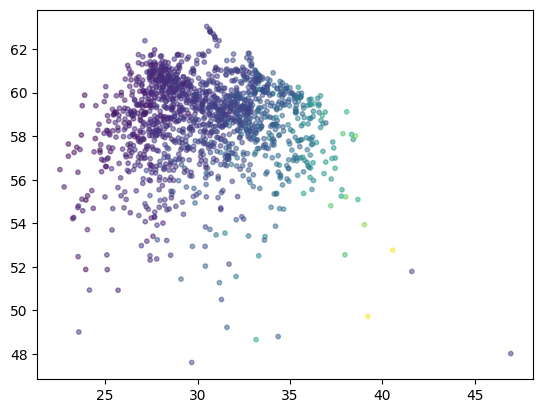

In [34]:
from pyspark.ml.functions import vector_to_array

CPs = coors_pca.withColumn("CP", vector_to_array("pca_features")) \
        .select([F.col("CP")[i] for i in range(2)]) \
        .toPandas()

plt.scatter(CPs.iloc[:,0], CPs.iloc[:,1], alpha=0.5, s=10, c=df.select("SalePrice").toPandas().values);
plt.show()

Parece haber un gradiente de color al movernos horizontalmente, que es equivalente a un gradiente de precio. También podemos ver que los casos se concentran cada vez más conforme subimos.



# Modelos

A la hora de hacer predicciones, podemos utilizar las nuevas variables obtenidas mediante PDA. No obstante, esto limita la interpretabilidad de los resultados, por lo que vamos a trabajar en su lugar con las variables originales.

Por otro lado, sí que nos interesa la tipificación, por lo que vamos a empezar preparando las variables y haciendo una partición train/test adecuada.

Los modelos que usaremos serán algunos de los de regresión que se encuentran en este [enlace](https://spark.apache.org/docs/latest/ml-classification-regression.html).

## Partición train/test

In [35]:
# Particion train/test
semilla = 33
(train_original, test_original) = df.randomSplit([0.8, 0.2], seed=semilla)

# Preparamos train y entrenamos el pipeline
train, pmodel_train = prepare_variables(train_original, encoded=True, columnas=train_original.columns)
train.show(3)

# Entreno test a partir del pipeline de train para que no afecte en el resultado
test = prepare_variables(test_original, columnas=train.columns, custom_pipeline_model=pmodel_train)
test.show(3)

+----------+-----------+-------+-----------+-----------+---------+------------+----------+----------+----------+---------+-----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+------------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+-------+------+------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+--------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------------+--------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+-----

## Modelo 1: Regresión Lineal

In [36]:
from pyspark.ml.regression import LinearRegression

target = "SalePrice"
feat = "features_scaled"

lr = LinearRegression(featuresCol=feat, labelCol=target)
m_lr = lr.fit(train)
predictions = m_lr.transform(test)
predictions.select("prediction", target).show(5)

+------------------+---------+
|        prediction|SalePrice|
+------------------+---------+
| 54397.56119864015|    55993|
|236437.06841202744|   250580|
| 204491.8326027334|   208300|
| 126232.9707647292|   125500|
|219964.05921728676|   220000|
+------------------+---------+
only showing top 5 rows



In [37]:
_ = eval_rendimiento(pred=predictions)

rmse = 30571.45728
mae = 18471.65154
r2 = 0.81948
rmsle = 0.15107


También podemos probar a eliminar algunas de las variables más correladas:

In [38]:
from pyspark.ml.regression import LinearRegression

target = "SalePrice"
feat = "features_scaled"

# Preparamos las nuevas variables
train1 = train_original.drop(*sobran_corr)
train1, pp = prepare_variables(train1, columnas=train1.columns, encoded=True)
test1 = prepare_variables(test_original.drop(*sobran_corr), columnas=train1.columns, custom_pipeline_model=pp)

# Regresión lineal
lr2 = LinearRegression(featuresCol=feat, labelCol=target)
m_lr2 = lr2.fit(train1)
predictions = m_lr2.transform(test1)

# Resultados
_ = eval_rendimiento(pred=predictions)

rmse = 31480.60856
mae = 19529.621
r2 = 0.80858
rmsle = 0.1784


No mejora... vamos a probar otra aproximación basándonos en la importancia de las variables.

### Importancia de las variables

Mediremos la importancia utilizando los coeficientes del modelo de regresión, porque todas están escaladas.

In [39]:
coefficients = m_lr.coefficients
feature_importance = sorted(list(zip(train.columns[:-2], map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

Feature Importance:
  GrLivArea: 15976.359
  2ndFlrSF: 15527.555
  YearBuilt: 9457.046
  OverallQual: 9335.775
  BsmtFinSF1: 9097.364
  TotalBsmtSF: 8543.479
  LotArea: 7211.162
  OverallCond: 6049.269
  SaleCondition_n: 5670.521
  PoolArea: 5401.796
  TotRmsAbvGrd: 5149.282
  MasVnrArea: 5036.353
  GarageYrBlt_n: 4458.661
  1stFlrSF: 4329.948
  GarageArea: 4293.056
  MSSubClass: 4057.239
  PoolQC_n: 3790.900
  GarageQual_n: 3268.966
  Fireplaces: 3231.496
  GarageCars: 3129.914
  BedroomAbvGr: 3068.735
  YearRemodAdd: 2759.340
  CentralAir_n: 2623.132
  FullBath: 2385.318
  ScreenPorch: 2380.140
  WoodDeckSF: 2220.003
  LandContour_n: 1997.780
  GarageType_n: 1884.260
  Electrical_n: 1778.094
  EnclosedPorch: 1722.619
  BsmtQual_n: 1686.009
  Alley_n: 1543.648
  Foundation_n: 1528.593
  BsmtUnfSF: 1464.374
  BsmtFinSF2: 1457.622
  ExterCond_n: 1412.727
  3SsnPorch: 1276.755
  YrSold: 1273.362
  MiscFeature_n: 1218.208
  RoofMatl_n: 1200.912
  Street_n: 1154.905
  Heating_n: 1099.586
 

Vamos a ir añadiendo variables hasta que tengamos un aumento del RMSE:

In [40]:
# Tomamos las variables más importantes en orden
features = [tupla[0] for tupla in feature_importance]
features = [item.split('_')[0] if '_' in item else item for item in features]
n_features = len(features)

# Inicialización de las variables
valen = [] # empezamos cogiendo la más importante
lr = LinearRegression(featuresCol=feat, labelCol=target)
best_rmsle = infinity
idx = 0

# Optimizar según el rmsle (métrica de Kaggle)
evaluador = RmsleEvaluator(targetCol=target, predictionCol="prediction")

for idx in range(n_features):
  var = features[idx]

  # Preparamos las variables
  train_importancia = train_original.select(*valen+[var, "SalePrice"])
  train_importancia, pp = prepare_variables(train_importancia, columnas=train_importancia.columns, encoded=True)
  test_importancia = prepare_variables(test_original.select(*valen+[var, "SalePrice"]), columnas=train_importancia.columns, custom_pipeline_model=pp)

  # Evaluación del modelo de regresión lineal
  rmsle = evaluador.evaluate(
      lr.fit(train_importancia).transform(test_importancia)
      )

  if rmsle < best_rmsle:
    best_rmsle = rmsle
    valen += [var]

  print(f"\r Variables probadas: {idx+1}/{n_features}", end="")
  idx += 1


 Variables probadas: 79/79

Con las variables que optimizan el modelo seleccionadas, podemos evaluarlo:

In [41]:
# Variables seleccionadas
train2 = train_original.select(*valen+["SalePrice"])
train2, pp = prepare_variables(train2, columnas=train2.columns, encoded=True)
test2 = prepare_variables(test_original.select(*valen+["SalePrice"]), columnas=train2.columns, custom_pipeline_model=pp)

# Modelo de regresión lineal óptimo
m_lr_optimo = lr.fit(train2)
predictions = m_lr_optimo.transform(test2)
_ = eval_rendimiento(pred=predictions)

rmse = 25903.01811
mae = 18384.24078
r2 = 0.8704
rmsle = 0.13571


## Modelo 2: GLM

Generalized Linear Model. Se asume que la salida tiene cierta forma:

+ Gaussiana: output continuo (link: identity, log, inverse).
+ Binomial: output binario.
+ Poisson: output conteo.
+ Gamma: output continuo (link: inverse, identity, log).
+ Tweedie: continuo, pero inflado de ceros.


In [42]:
from pyspark.ml.regression import GeneralizedLinearRegression

families = ["gaussian", "gamma"]
links = ["identity", "inverse", "log"]
best_parameters = ["family", "link", infinity] # family - link - rmsle

evaluador = RmsleEvaluator(targetCol=target, predictionCol="prediction")


for family in families:
  for link in links:
    # Actualizar modelo
    glr = GeneralizedLinearRegression(family=family, link=link,
                                  maxIter=10, regParam=0.3,
                                  featuresCol=feat, labelCol=target)

    # Evaluación del modelo
    rmsle = evaluador.evaluate(
        glr.fit(train).transform(test)
    )

    # Actualizar resultados
    if best_parameters[2] > rmsle:
      best_parameters[0] = family
      best_parameters[1] = link
      best_parameters[2] = rmsle

print("Mejor modelo:\n",
      f"+ Familia: {best_parameters[0]}\n",
      f"+ Link: {best_parameters[1]}\n",
      f"+ RMSLE: {round(best_parameters[2], 2)}")

Mejor modelo:
 + Familia: gamma
 + Link: identity
 + RMSLE: 0.12


In [43]:
# Best GLM
glr = GeneralizedLinearRegression(family=best_parameters[0],
                                  link=best_parameters[1],
                                  maxIter=10, regParam=0.3,
                                  featuresCol=feat, labelCol=target)

best_glm_model = glr.fit(train)
pred = best_glm_model.transform(test)
print("--- Mejor GLM ---")
_ = eval_rendimiento(pred=pred)

--- Mejor GLM ---
rmse = 24047.46122
mae = 16294.46956
r2 = 0.8883
rmsle = 0.12463


### Importancia de las variables

Vamos a repetir el tratamiento de las importancias de las variables que hicimos para el modelo de regresión lineal.

In [44]:
# Obtención de las variables y su importancia
coefficients = best_glm_model.coefficients
feature_importance = sorted(list(zip(train.columns[:-2], map(abs, coefficients))), key=lambda x: x[1], reverse=True)

# Ordenamos las variablespor la importancia de cada una
features = [tupla[0] for tupla in feature_importance]
features = [item.split('_')[0] if '_' in item else item for item in features]
n_features = len(features)

# Inicialización de las variables
valen_glr = [] # empezamos cogiendo la más importante
glr = GeneralizedLinearRegression(family=best_parameters[0],
                                  link=best_parameters[1],
                                  maxIter=10, regParam=0.3,
                                  featuresCol=feat, labelCol=target)
best_rmsle = infinity
idx = 0

# Optimizar según el rmsle (métrica de Kaggle)
evaluador = RmsleEvaluator(targetCol=target, predictionCol="prediction")

for idx in range(n_features):
  var = features[idx]

  # Preparamos las variables
  train_importancia = train_original.select(*valen_glr+[var, "SalePrice"])
  train_importancia, pp = prepare_variables(train_importancia, columnas=train_importancia.columns, encoded=True)
  test_importancia = prepare_variables(test_original.select(*valen_glr+[var, "SalePrice"]), columnas=train_importancia.columns, custom_pipeline_model=pp)

  # Evaluación del modelo de regresión lineal
  rmsle = evaluador.evaluate(
      glr.fit(train_importancia).transform(test_importancia)
      )

  if rmsle < best_rmsle:
    best_rmsle = rmsle
    valen_glr += [var]

  print(f"\r Variables probadas: {idx+1}/{n_features}", end="")
  idx += 1

 Variables probadas: 79/79

In [45]:
# Preparamos las variables seleccionadas
train2 = train_original.select(*valen_glr+["SalePrice"])
train2, pp = prepare_variables(train2, columnas=train2.columns, encoded=True)
test2 = prepare_variables(test_original.select(*valen_glr+["SalePrice"]), columnas=train2.columns, custom_pipeline_model=pp)

# Evaluamos el modelo óptimo
m_glr_optimo = glr.fit(train2)
predictions = m_glr_optimo.transform(test2)
_ = eval_rendimiento(pred=predictions)

rmse = 24519.77998
mae = 15603.67189
r2 = 0.88387
rmsle = 0.11262


También podemos probar a evaluar el modelo para distintos valores de "regParam". Vamos a hacerlo mediante validación cruzada:

In [46]:
# Definimos el modelo
glr = GeneralizedLinearRegression(family=best_parameters[0],
                                  link=best_parameters[1],
                                  maxIter=10,
                                  featuresCol=feat, labelCol=target)

# Hacemos el grid para regParam
param_grid = ParamGridBuilder() \
    .addGrid(glr.regParam, [0.0, 0.5, 1]).build()

# Crossvalidation
crossval_glr = CrossValidator(estimator=glr,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluador,
                          numFolds=5)  # Number of folds for cross-validation

cv_model = crossval_glr.fit(train2)

# Evaluamos para ver si tenemos una mejora significativa
_ = eval_rendimiento(pred=cv_model.bestModel.transform(test2))

rmse = 26373.65655
mae = 16484.06235
r2 = 0.86565
rmsle = 0.11823


No parece mejorar notablemente. Vamos a quedarnos con el modelo óptimo que hemos encontrado antes.

Vamos a guardar las variables que hemos usado:

In [47]:
import json
with open(output_path.format("variables_glr"), "w") as fp:
  json.dump(valen_glr, fp)

## Modelo 3: decision tree regression

In [48]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol=feat, labelCol=target, seed=semilla)

pred = dt.fit(train).transform(test)
_ = eval_rendimiento(pred=pred)

rmse = 34535.66876
mae = 24420.17931
r2 = 0.76962
rmsle = 0.19595


## Modelo 4: Random Forest Regression

Empezando haciendo el modelo por defecto para evaluar la importancia de las variables. Para ello, vamos a utilizar datos a los que no se les haya aplicado el OneHotEnconding, ya que estos añaden una variable por cada categoría en las variables categóricas, dificultando el estudio.

In [49]:
from pyspark.ml.regression import RandomForestRegressor

# Preparamos variables (sin OneHotEncoding)
train3, pp = prepare_variables(train_original, columnas=train_original.columns, encoded=False) # para que no se generen multiples variables por cada categorica
test3 = prepare_variables(test_original, columnas=train3.columns, custom_pipeline_model=pp)

# Entrenamos el modelo y lo evaluamos
RF = RandomForestRegressor(featuresCol=feat, labelCol=target, seed=semilla)
m = RF.fit(train3)
pred = m.transform(test3)
_ = eval_rendimiento(pred=pred)

rmse = 27542.67799
mae = 20599.49927
r2 = 0.85347
rmsle = 0.17248


Empezamos con un rmsle relativamente bajo, así que vamos a intentar mejorarlo. Para ello, vamos a calcular la importancia de las variables:

In [50]:
importancia = m.featureImportances.toArray()
importancia = pd.DataFrame(importancia, columns=["Importancia"])
importancia.index = train3.columns[:-2]
importancia = importancia.sort_values(by="Importancia", ascending=False)
importancia["Acumulada"] = importancia.cumsum()
display(importancia.head(23))

,Importancia,Acumulada
OverallQual,0.331406,0.331406
GarageCars,0.173700,0.505106
ExterQual_n,0.085520,0.590626
GrLivArea,0.062064,0.652690
TotalBsmtSF,0.045634,0.698324
TotRmsAbvGrd,0.040720,0.739044
1stFlrSF,0.037657,0.776701
GarageArea,0.031445,0.808146
YearBuilt,0.022617,0.830763
KitchenQual_n,0.017855,0.848618


Originalmente teníamos 79 variables explicativas, pero hemos podido mantener un 95% de importancia quedándonos solo con 23. Esto será útil en el siguiente paso, ya que vamos a necesitar entrenar varias veces el modelo para encontrar el óptimo.

Empezamos entonces seleccionando esas variables únicamente:

In [51]:
# Seleccionamos variables hasta GarageYrBlt
variables_mas_importantes = importancia[importancia.Importancia >= importancia.loc["GarageYrBlt_n", "Importancia"]].index.tolist()
variables_mas_importantes = [item.split('_')[0] if '_' in item else item for item in variables_mas_importantes]

# Preparamos las variables (con OneHotEncoding esta vez)
train_RF, pp = prepare_variables(train_original.select(variables_mas_importantes + ["SalePrice"]), columnas = variables_mas_importantes + ["SalePrice"])
test_RF = prepare_variables(test_original, columnas=train_RF.columns, custom_pipeline_model=pp)

#Evaluamos el modelo
m = RF.fit(train_RF)
pred = m.transform(test_RF)
_ = eval_rendimiento(pred=pred)

rmse = 27531.62282
mae = 20429.07814
r2 = 0.85359
rmsle = 0.17146


Seguimos teniendo buenos resultados y hemos eliminado la mayoría de variables.

### Modelo RF óptimo

In [52]:
grid_maxDepth = np.arange(5,21,2) # por defecto toma el valor 5
evaluador = RmsleEvaluator(targetCol=target, predictionCol="prediction")
registro = [] # (maxDepth, rmsle)

for mD in grid_maxDepth:
  m_RF = RandomForestRegressor(featuresCol=feat, labelCol=target,
                               seed=semilla, maxDepth=mD)

  rmsle = evaluador.evaluate(
      m_RF.fit(train_RF).transform(test_RF)
  )

  registro.append((mD, rmsle))
  print(f"\rmaxDepth {mD} hecho!", end="")


maxDepth 19 hecho!


Mejor valor de maxDepth



,maxDepth,RMSLE
7,19,0.138539
6,17,0.138718
4,13,0.138837


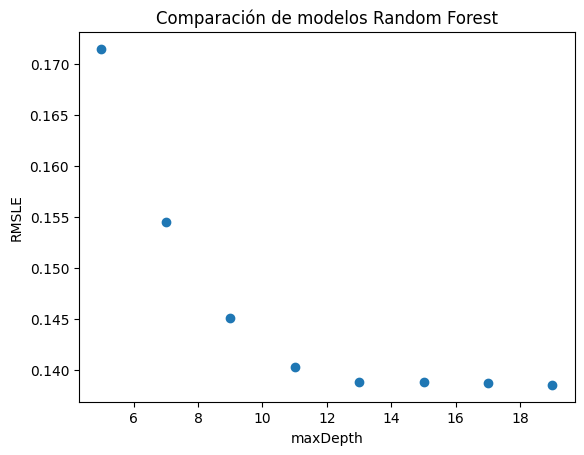

In [53]:
from matplotlib import pyplot as plt

registroPD = pd.DataFrame(registro)
registroPD.columns = ["maxDepth", "RMSLE"]
print("\nMejor valor de maxDepth\n")
display(registroPD.sort_values("RMSLE").head(3))
print("")

best_mD = registroPD.sort_values("RMSLE").head(1).loc[:, "maxDepth"].values[0]


fig = plt.figure();
plt.scatter(registroPD.iloc[:,0], registroPD.iloc[:,1]);
plt.xlabel("maxDepth")
plt.ylabel("RMSLE")
plt.title("Comparación de modelos Random Forest")
plt.show();

In [54]:
grid_numTrees = np.arange(17, 23, 1) # por defecto toma el valor 20
grid_maxDepth = np.arange(best_mD-1, best_mD+2, 1) # Evaluamos en el entorno del maxDepth óptimo

registro = pd.DataFrame(np.zeros((grid_numTrees.shape[0] * grid_maxDepth.shape[0], 3)))
registro.columns = ["numTrees", "maxDepth", "RMSLE"]

idx_insert = 0
for mD in grid_maxDepth:
  for nT in grid_numTrees:
    m_RF = RandomForestRegressor(featuresCol=feat, labelCol=target,
                                seed=semilla, maxDepth=mD,
                                numTrees=nT)

    rmsle = evaluador.evaluate(
        m_RF.fit(train_RF).transform(test_RF)
    )

    registro.iloc[idx_insert, :] = [nT, mD, rmsle]
    idx_insert += 1
  print(f"\rmaxDepth {mD} hecho!", end="")

maxDepth 20 hecho!


Mejor valor de numTrees



,numTrees,maxDepth,RMSLE
13,18.0,20.0,0.137263
1,18.0,18.0,0.137269
7,18.0,19.0,0.137271


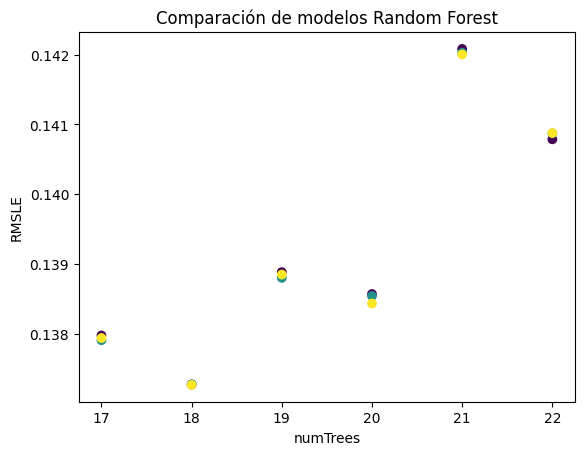

In [55]:
print("\nMejor valor de numTrees\n")
display(registro.sort_values("RMSLE").head(3))
print("")

fig = plt.figure();
plt.scatter(registro.loc[:,"numTrees"], registro.loc[:,"RMSLE"], c=registro.loc[:,"maxDepth"]);
plt.xlabel("numTrees")
plt.ylabel("RMSLE")
plt.title("Comparación de modelos Random Forest")
plt.show();

best_mD_final = registro.sort_values("RMSLE").head(1).loc[:, "maxDepth"].values[0]
best_nT_final = registro.sort_values("RMSLE").head(1).loc[:, "numTrees"].values[0]



In [56]:
bestRF = RandomForestRegressor(featuresCol=feat, labelCol=target,
                               seed=semilla,
                               maxDepth=best_mD_final,
                               numTrees=best_nT_final)
m_bestRF = bestRF.fit(train_RF)
pred = m_bestRF.transform(test_RF)
_ = eval_rendimiento(pred=pred)

rmse = 23315.96001
mae = 16912.3302
r2 = 0.89499
rmsle = 0.13726


## Modelo 5: Gradient Boosted Trees

In [57]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol=feat, labelCol=target, seed=semilla)
m_gbt = gbt.fit(train3)
pred = m_gbt.transform(test3)
_ = eval_rendimiento(pred=pred)

rmse = 33601.97894
mae = 21948.49796
r2 = 0.78191
rmsle = 0.17131


### Importancia de las variables

De nuevo, vamos a hacer un estudio de la importancia de las variables con la intención de mejorar la eficiencia de la evaluación del modelo. En este caso, como el modelo GBT es más costoso de evaluar, vamos a quedarnos en un 90%:

In [58]:
importancia = m_gbt.featureImportances.toArray()
importancia = pd.DataFrame(importancia, columns=["Importancia"])
importancia.index = train3.columns[:-2]
importancia = importancia.sort_values(by="Importancia", ascending=False)
importancia["Acumulada"] = importancia.cumsum()
display(importancia.head(26))

,Importancia,Acumulada
OverallQual,0.396980,0.396980
GrLivArea,0.068726,0.465707
YearBuilt,0.038185,0.503892
LotFrontage,0.035047,0.538939
YearRemodAdd,0.034746,0.573686
LotArea,0.032970,0.606656
OverallCond,0.031340,0.637996
TotalBsmtSF,0.025711,0.663707
1stFlrSF,0.023113,0.686820
GarageYrBlt_n,0.021234,0.708054


In [59]:
variables_mas_importantes = importancia[importancia.Importancia >= importancia.loc["LotShape_n", "Importancia"]].index.tolist()
variables_mas_importantes = [item.split('_')[0] if '_' in item else item for item in variables_mas_importantes]

train_gbt, pp = prepare_variables(train_original.select(variables_mas_importantes + ["SalePrice"]), columnas = variables_mas_importantes + ["SalePrice"])
test_gbt = prepare_variables(test_original, columnas=train_gbt.columns, custom_pipeline_model=pp)

m = gbt.fit(train_gbt)
pred = m.transform(test_gbt)
_ = eval_rendimiento(pred=pred)

rmse = 29205.4679
mae = 20450.61966
r2 = 0.83525
rmsle = 0.15939


### Modelo GBT óptimo

In [60]:
grid_maxDepth = np.arange(2,7,1) # por defecto toma el valor 5
evaluador = RmsleEvaluator(targetCol=target, predictionCol="prediction")
registro = [] # (maxDepth, rmsle)

for mD in grid_maxDepth:
  gbt = GBTRegressor(featuresCol=feat, labelCol=target, seed=semilla,
                     maxDepth=mD)
  rmsle = evaluador.evaluate(gbt.fit(train_gbt).transform(test_gbt))

  registro.append((mD, rmsle))
  print(f"\rmaxDepth {mD} hecho!", end="")


maxDepth 6 hecho!


Mejor valor de maxDepth



,maxDepth,RMSE
2,4,0.159326
3,5,0.159394
4,6,0.161928


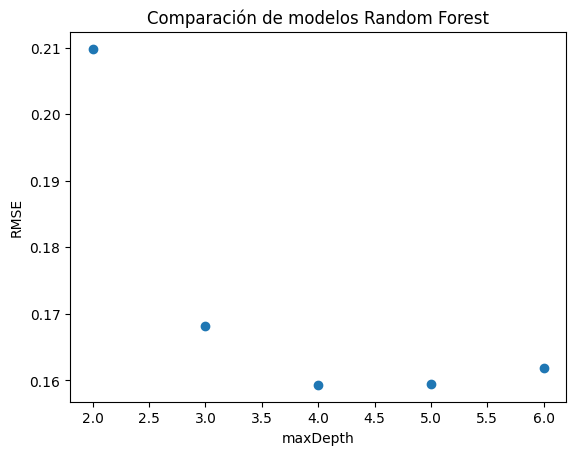

In [61]:
from matplotlib import pyplot as plt

registroPD = pd.DataFrame(registro)
registroPD.columns = ["maxDepth", "RMSE"]
print("\nMejor valor de maxDepth\n")
display(registroPD.sort_values("RMSE").head(3))
print("")

best_mD = registroPD.sort_values("RMSE").head(1).loc[:, "maxDepth"].values[0]


fig = plt.figure();
plt.scatter(registroPD.iloc[:,0], registroPD.iloc[:,1]);
plt.xlabel("maxDepth")
plt.ylabel("RMSE")
plt.title("Comparación de modelos Random Forest")
plt.show();

In [62]:
grid_lossType = ["squared", "absolute"] # por defecto "squared"
grid_maxDepth = np.arange(best_mD-1, best_mD+2, 1)

evaluador = RmsleEvaluator(targetCol=target, predictionCol="prediction")

registro = pd.DataFrame(np.zeros((len(grid_lossType) * grid_maxDepth.shape[0], 3)))
registro.columns = ["lossType", "maxDepth", "RMSLE"]

idx_insert = 0
for mD in grid_maxDepth:
  for lT in grid_lossType:
    m = GBTRegressor(featuresCol=feat, labelCol=target, seed=semilla,
                     maxDepth=mD, lossType=lT)

    pred = m.fit(train_gbt).transform(test_gbt)
    rmsle = evaluador.evaluate(pred)

    registro.iloc[idx_insert, :] = [lT, mD, rmsle]
    idx_insert += 1
  print(f"\rmaxDepth {mD} hecho!", end="")

maxDepth 5 hecho!


Mejor valor de lossType



,lossType,maxDepth,RMSLE
2,squared,4.0,0.159326
4,squared,5.0,0.159394
0,squared,3.0,0.168200


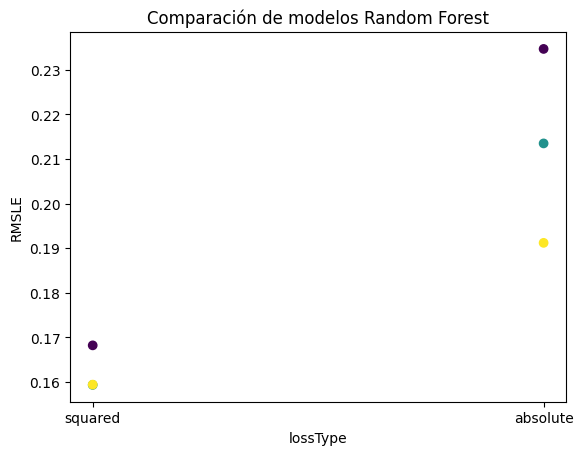

In [63]:
print("\nMejor valor de lossType\n")
display(registro.sort_values("RMSLE").head(3))
print("")

fig = plt.figure();
plt.scatter(registro.loc[:,"lossType"], registro.loc[:,"RMSLE"], c=registro.loc[:,"maxDepth"]);
plt.xlabel("lossType")
plt.ylabel("RMSLE")
plt.title("Comparación de modelos Random Forest")
plt.show();

best_mD_final = registro.sort_values("RMSLE").head(1).loc[:, "maxDepth"].values[0]
best_lT_final = registro.sort_values("RMSLE").head(1).loc[:, "lossType"].values[0]



In [64]:
grid_stepSize = np.arange(0.05, 0.20, 0.05) # por defecto 0.1

evaluador = RmsleEvaluator(targetCol=target, predictionCol="prediction")

registro = pd.DataFrame(np.zeros((grid_stepSize.shape[0], 2)))
registro.columns = ["stepSize", "RMSLE"]

idx_insert = 0
for sZ in grid_stepSize:
  m = GBTRegressor(featuresCol=feat, labelCol=target, seed=semilla,
                   maxDepth=best_mD_final,
                   lossType=best_lT_final,
                   stepSize = sZ)

  rmsle = evaluador.evaluate(
      m.fit(train_gbt).transform(test_gbt)
  )

  registro.iloc[idx_insert, :] = [sZ, rmsle]
  idx_insert += 1


Mejor valor de stepSize



,stepSize,RMSLE
3,0.20,0.150599
2,0.15,0.154138
1,0.10,0.159326


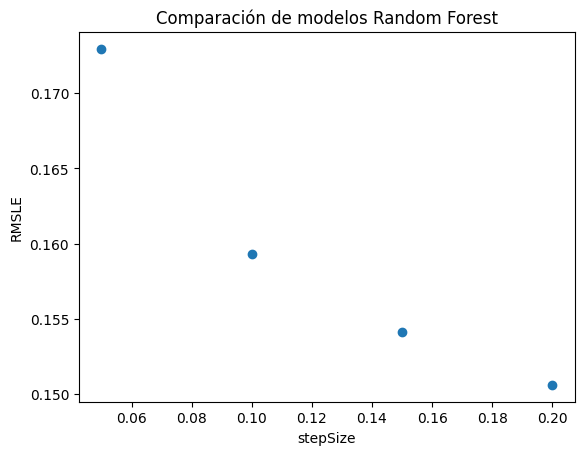

In [65]:
print("\nMejor valor de stepSize\n")
display(registro.sort_values("RMSLE").head(3))
print("")

fig = plt.figure();
plt.scatter(registro.loc[:,"stepSize"], registro.loc[:,"RMSLE"]);
plt.xlabel("stepSize")
plt.ylabel("RMSLE")
plt.title("Comparación de modelos Random Forest")
plt.show();

best_sZ_final = registro.sort_values("RMSLE").head(1).loc[:, "stepSize"].values[0]



In [66]:
bestGBT = GBTRegressor(featuresCol=feat, labelCol=target, seed=semilla,
                       maxDepth=best_mD_final,
                       lossType=best_lT_final,
                       stepSize = best_sZ_final)
m_bestGBT = bestGBT.fit(train_gbt)
pred = m_bestGBT.transform(test_gbt)
_ = eval_rendimiento(pred=pred)

rmse = 26940.39425
mae = 19065.44313
r2 = 0.85981
rmsle = 0.1506


# Kaggle



## Carga de datos e imputación de NAs

In [67]:
path = input_path.format("test.csv")
df_kaggle = spark.read.csv(path, header=True, inferSchema=True)

columnas_test = df_kaggle.columns
numericas_test = [c for c in numericas if c in columnas_test]

df_kaggle = convertir_numericas(df_kaggle, numericas=numericas_test) # variables numericas

# NAs de variables numéricas
expr = [F.sum(F.col(c).isNull().cast(IntegerType())).alias(c) for c in columnas_test]
nas = df_kaggle.agg(*expr).toPandas() # son pocos datos, podemos trabajarlos en local
display(nas.loc[:, (nas>0).values[0]])

# NAs de variables categóricas
expr = [F.sum((F.col(c) == "NA").cast(IntegerType())).alias(c) for c in columnas_test if c in categoricas if c not in categoricas_con_NAs_falsos]
nas = df_kaggle.agg(*expr).toPandas() # son pocos datos, podemos trabajarlos en local
display(nas.loc[:, (nas>0).values[0]])

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageCars,GarageArea
0,227,15,1,1,1,1,2,2,1,1


,MSZoning,Utilities,Exterior1st,Exterior2nd,MasVnrType,KitchenQual,Functional,GarageYrBlt,SaleType
0,4,2,1,1,16,1,2,78,1


Las variables que ya hemos tratado en train son: LotFrontage, MasVnrArea, MasVnrType, GarageYrBlt. Para estas ya conocemos el método a seguir para imputar los valores.

Por otro lado, tenemos las variables: BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath, GarageCars, GarageArea, MSZoning, Utilities, Exterior1st, Exterior2nd, KitchenQual, Functional, SaleType.

### BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath

In [68]:
cols = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath", "BsmtQual"]
temp = df_kaggle.where(df_kaggle.BsmtFinSF1.isNull()).select(cols)
temp.show()

+----------+----------+---------+-----------+------------+------------+--------+
|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|BsmtFullBath|BsmtHalfBath|BsmtQual|
+----------+----------+---------+-----------+------------+------------+--------+
|      NULL|      NULL|     NULL|       NULL|        NULL|        NULL|      NA|
+----------+----------+---------+-----------+------------+------------+--------+



Todas coinciden con el caso en el que no hay Sótano (lo sabemos gracias a BsmtQual). Como hacen referencia a cantidades y superficies, vamos a imputarlas como cero.

### GarageCars, GarageArea

In [69]:
cols = ["GarageCars", "GarageArea", "GarageYrBlt", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]
temp = df_kaggle.where(df_kaggle.GarageCars.isNull()).select(cols)
temp.show()

+----------+----------+-----------+----------+------------+----------+----------+
|GarageCars|GarageArea|GarageYrBlt|GarageType|GarageFinish|GarageQual|GarageCond|
+----------+----------+-----------+----------+------------+----------+----------+
|      NULL|      NULL|         NA|    Detchd|          NA|        NA|        NA|
+----------+----------+-----------+----------+------------+----------+----------+



La columna GarageType se contradice con las columnas GarageFinish, GarageQual y GarageCond, que nos indican que no hay garaje. Vamos a comprobar cuáles son los valores que toma la variable GarageType cuando la GarageFinish es "NA" y los que toma GarageFinish cuando GarageType es Detchd:

In [70]:
cols = ["GarageCars", "GarageArea", "GarageYrBlt", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]
df_kaggle.filter(df_kaggle.GarageFinish == "NA").groupBy("GarageType").count().show()
df_kaggle.filter(df_kaggle.GarageType == "Detchd").groupBy("GarageFinish").count().show()

+----------+-----+
|GarageType|count|
+----------+-----+
|        NA|   76|
|    Detchd|    2|
+----------+-----+

+------------+-----+
|GarageFinish|count|
+------------+-----+
|         RFn|   15|
|          NA|    2|
|         Fin|   10|
|         Unf|  365|
+------------+-----+



Tenemos 2 casos en los que, sin tener garaje, se les ha asignado como Detchd. Luego los cambiamos a NA, además de imputar los NA como cero de las variables numéricas como 0.

### MSZoning

Vamos a fijarnos en las variables más correladas con MSZoning para ayudarnos a imputar este valor.

In [71]:
correlaciones_local.loc[:,"MSZoning_n"].sort_values(ascending=False)

MSZoning_n       1.000000
Alley_n          0.370835
MSSubClass       0.280306
BldgType_n       0.220096
CentralAir_n     0.214583
                   ...   
LotShape_n      -0.188404
FireplaceQu_n   -0.191213
TotalBsmtSF     -0.204741
Fireplaces      -0.211995
1stFlrSF        -0.252797
Name: MSZoning_n, Length: 79, dtype: float64

In [72]:
cols = ["MSZoning", "MSSubClass", "BldgType", "Alley", "CentralAir", "Fireplaces"]
temp = df_kaggle.where(df_kaggle.MSZoning == "NA").select(cols)
temp.show()

+--------+----------+--------+-----+----------+----------+
|MSZoning|MSSubClass|BldgType|Alley|CentralAir|Fireplaces|
+--------+----------+--------+-----+----------+----------+
|      NA|        30|    1Fam|   NA|         N|         0|
|      NA|        20|    1Fam|   NA|         N|         0|
|      NA|        70|    1Fam|   NA|         Y|         0|
|      NA|        20|    1Fam|   NA|         Y|         0|
+--------+----------+--------+-----+----------+----------+



In [73]:
cuenta = df.filter(((F.col("BldgType") == "1Fam") & (F.col("Alley") == "NA") & (F.col("Fireplaces") == 0))).groupBy("MSZoning").count()
cuenta.show()

sorted_counts = cuenta.orderBy(F.col("count").desc())
moda_MS = sorted_counts.select("MSZoning").first()[0]

+--------+-----+
|MSZoning|count|
+--------+-----+
| C (all)|    7|
|      RH|    8|
|      FV|   17|
|      RL|  398|
|      RM|   73|
+--------+-----+



### Utilities

Elegimos variables que, por definición, están relacionadas con Utilities:

In [74]:
cols = ["Utilities", "Electrical", "Heating", "CentralAir"]
temp = df_kaggle.where(df_kaggle.Utilities == "NA").select(cols)
temp.show()

+---------+----------+-------+----------+
|Utilities|Electrical|Heating|CentralAir|
+---------+----------+-------+----------+
|       NA|     FuseA|   GasA|         N|
|       NA|     FuseA|   GasA|         Y|
+---------+----------+-------+----------+



In [75]:
cuenta = df.filter(((F.col("Electrical") == "FuseA") | (F.col("Heating") == "GasA"))).groupBy("Utilities").count()
cuenta.show()

sorted_counts = cuenta.orderBy(F.col("count").desc())
moda_utilities = sorted_counts.select("Utilities").first()[0]

+---------+-----+
|Utilities|count|
+---------+-----+
|   NoSeWa|    1|
|   AllPub| 1434|
+---------+-----+



### Exterior1st, Exterior2nd

In [76]:
cols = ["Exterior1st", "Exterior2nd", "ExterQual", "ExterCond", "Foundation"]
temp = df_kaggle.where(df_kaggle.Exterior1st == "NA").select(cols)
temp.show()

+-----------+-----------+---------+---------+----------+
|Exterior1st|Exterior2nd|ExterQual|ExterCond|Foundation|
+-----------+-----------+---------+---------+----------+
|         NA|         NA|       TA|       TA|     PConc|
+-----------+-----------+---------+---------+----------+



Para asignar la moda, vamos a restringirnos a los casos en los que las 3 variables que hemos usado para guiarnos toman los valores que nos han salido:

In [77]:
cuenta = df.filter(((F.col("ExterQual") == "TA") & (F.col("ExterCond") == "TA") & (F.col("Foundation") == "PConc"))).groupBy("Exterior1st").count()
cuenta.show()

sorted_counts = cuenta.orderBy(F.col("count").desc())
moda_1 = sorted_counts.select("Exterior1st").first()[0]

+-----------+-----+
|Exterior1st|count|
+-----------+-----+
|    HdBoard|   25|
|    CemntBd|    5|
|    WdShing|    1|
|    Plywood|   10|
|    Wd Sdng|   24|
|    MetalSd|   14|
|      Stone|    1|
|    AsbShng|    4|
|    BrkFace|    3|
|    VinylSd|   72|
+-----------+-----+



In [78]:
cuenta = df.filter(((F.col("ExterQual") == "TA") & (F.col("ExterCond") == "TA") & (F.col("Foundation") == "PConc"))).groupBy("Exterior2nd").count()
cuenta.show()

sorted_counts = cuenta.orderBy(F.col("count").desc())
moda_2 = sorted_counts.select("Exterior2nd").first()[0]

+-----------+-----+
|Exterior2nd|count|
+-----------+-----+
|    CmentBd|    5|
|    HdBoard|   25|
|    Plywood|   13|
|    Wd Shng|    3|
|    ImStucc|    1|
|    Wd Sdng|   20|
|     Stucco|    2|
|    MetalSd|   14|
|      Stone|    1|
|    AsbShng|    3|
|    BrkFace|    1|
|    VinylSd|   71|
+-----------+-----+



### KitchenQual

In [79]:
correlaciones_local.loc[:,"KitchenQual_n"].sort_values(ascending=False)

KitchenQual_n     1.000000
ExterQual_n       0.560834
OverallQual       0.441213
YearRemodAdd      0.386459
GrLivArea         0.309502
                    ...   
Fence_n          -0.139443
GarageYrBlt_n    -0.197131
BsmtFinType1_n   -0.231860
HeatingQC_n      -0.250221
Foundation_n     -0.303289
Name: KitchenQual_n, Length: 79, dtype: float64

In [80]:
cols = ["KitchenQual", "KitchenAbvGr", "ExterQual", "OverallQual"]
temp = df_kaggle.where(df_kaggle.KitchenQual == "NA").select(cols)
temp.show()

+-----------+------------+---------+-----------+
|KitchenQual|KitchenAbvGr|ExterQual|OverallQual|
+-----------+------------+---------+-----------+
|         NA|           1|       TA|          5|
+-----------+------------+---------+-----------+



In [81]:
cuenta = df.filter(((F.col("KitchenAbvGr") == 1) & (F.col("ExterQual") == "TA") & (F.col("OverallQual") == 5))).groupBy("KitchenQual").count()
cuenta.show()

sorted_counts = cuenta.orderBy(F.col("count").desc())
moda_kitchen = sorted_counts.select("KitchenQual").first()[0]

+-----------+-----+
|KitchenQual|count|
+-----------+-----+
|         Gd|   50|
|         Ex|    8|
|         Fa|    8|
|         TA|  277|
+-----------+-----+



### Functional

In [82]:
correlaciones_local.loc[:,"Functional_n"].sort_values(ascending=False)

Functional_n      1.000000
BsmtCond_n        0.160613
Foundation_n      0.143333
BsmtFinSF2        0.125479
BsmtFinType1_n    0.125043
                    ...   
MasVnrArea       -0.076040
GarageCars       -0.081417
OverallCond      -0.118978
OverallQual      -0.137160
YearBuilt        -0.138408
Name: Functional_n, Length: 79, dtype: float64

In [83]:
cols = ["Functional", "BsmtCond", "Foundation", "YearBuilt"]
temp = df_kaggle.where(df_kaggle.Functional == "NA").select(cols)
temp.show()

+----------+--------+----------+---------+
|Functional|BsmtCond|Foundation|YearBuilt|
+----------+--------+----------+---------+
|        NA|      NA|      Slab|     1952|
|        NA|      Fa|    CBlock|     1910|
+----------+--------+----------+---------+



In [84]:
cuenta = df.groupBy("Functional").count()
cuenta.show()

sorted_counts = cuenta.orderBy(F.col("count").desc())
moda_functional = sorted_counts.select("Functional").first()[0]

+----------+-----+
|Functional|count|
+----------+-----+
|      Maj1|   14|
|       Sev|    1|
|      Min2|   34|
|      Min1|   31|
|       Typ| 1360|
|      Maj2|    5|
|       Mod|   15|
+----------+-----+



### SaleType

In [85]:
cols = ["SaleType", "SaleCondition", "MSSubClass", "MSZoning"]
temp = df_kaggle.where(df_kaggle.SaleType == "NA").select(cols)
temp.show()

+--------+-------------+----------+--------+
|SaleType|SaleCondition|MSSubClass|MSZoning|
+--------+-------------+----------+--------+
|      NA|       Normal|        20|      RL|
+--------+-------------+----------+--------+



In [86]:
cuenta = df.filter(((F.col("SaleCondition") == "Normal") & (F.col("MSSubClass") == 20) & (F.col("MSZoning") == "RL"))).groupBy("SaleType").count()
cuenta.show()

sorted_counts = cuenta.orderBy(F.col("count").desc())
moda_SaleType = sorted_counts.select("SaleType").first()[0]

+--------+-----+
|SaleType|count|
+--------+-----+
|     COD|   12|
|   ConLI|    1|
|      WD|  398|
+--------+-----+



## Conclusión

In [87]:
# Categóricas (tienen "NA" em forma de string)
df_kaggle = df_kaggle.replace("NA", "None", "MasVnrType")
df_kaggle = df_kaggle.replace("NA", moda_electrical, "Electrical")
df_kaggle = df_kaggle.replace("NA", moda_MS, "MSZoning")
df_kaggle = df_kaggle.replace("NA", moda_utilities, "Utilities")
df_kaggle = df_kaggle.replace("NA", moda_1, "Exterior1st")
df_kaggle = df_kaggle.replace("NA", moda_2, "Exterior2nd")
df_kaggle = df_kaggle.replace("NA", moda_kitchen, "KitchenQual")
df_kaggle = df_kaggle.replace("NA", moda_functional, "Functional")
df_kaggle = df_kaggle.replace("NA", moda_SaleType, "SaleType")

# GarageYrBlt: conversión a categórica
df_kaggle = df_kaggle.withColumn("GarageYrBlt", F.col("GarageYrBlt").cast("string"))
df_kaggle = df_kaggle.fillna("NoGarage", "GarageYrBlt")
df_kaggle = df_kaggle.replace("NA", "NoGarage", "GarageYrBlt") # por si no son Null

# GarageType: corregir valores Detchd -> NA cuando no hay garaje
df_kaggle = df_kaggle.withColumn("GarageType",
                                 F.when((F.col("GarageType") == "Detchd") &
                                      (F.col("GarageFinish") == "NA"),
                                      "NA"
                                      ).otherwise(F.col("GarageType")))

# Numéricas (tienen NA)
df_kaggle = df_kaggle.fillna(0, ["LotFrontage", "MasVnrArea"])
df_kaggle = df_kaggle.fillna(0, ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF",
                                 "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"])
df_kaggle = df_kaggle.fillna(0, ["GarageCars", "GarageArea"])

# --- o ---

# Comprobación: numéricas
expr = [F.sum(F.col(c).isNull().cast(IntegerType())).alias(c) for c in columnas_test]
nas = df_kaggle.agg(*expr).toPandas() # son pocos datos, podemos trabajarlos en local
display(nas.loc[:, (nas>0).values[0]])

# Comprobación: categóricas
expr = [F.sum((F.col(c) == "NA").cast(IntegerType())).alias(c) for c in categoricas if c not in categoricas_con_NAs_falsos]
nas = df_kaggle.agg(*expr).toPandas() # son pocos datos, podemos trabajarlos en local
display(nas.loc[:, (nas>0).values[0]])

""
0


""
0


Ahora que tenemos tanto train como test sin NAs, vamos a guardarlos para evitar sobrecargas de memoria:

In [88]:
df.write.csv(output_path.format("train_entrega.csv"), header=True, mode="overwrite")
df_kaggle.write.csv(output_path.format("test_entrega.csv"), header=True, mode="overwrite")

## Preparación de la entrega a Kaggle

In [89]:
# Reseteamos spark
spark.stop()

import findspark
findspark.init()

# Inicializamos la conexión con el motor de ejecución de Spark:
from pyspark.sql import SparkSession
# también tenemos una api de pandas para trabajar con tablas
spark = SparkSession.builder.master("local[*]").appName("nb03") \
    .getOrCreate()
sc = spark.sparkContext

# Cargamos dataframes de nuevo
train_entrega = spark.read.csv(output_path.format("train_entrega.csv"), header=True, inferSchema=True)
test_entrega = spark.read.csv(output_path.format("test_entrega.csv"), header=True, inferSchema=True)

# Variables a utilizar
import json
with open(output_path.format("variables_glr"), "r") as fp:
    valen_glr = json.load(fp)

In [90]:
# Variables
var_cat_intermedio = [c + "_index" for c in categoricas]
var_cat_output = [c + "_out" for c in categoricas]
all_vars = numericas[:-1] + var_cat_output

# Pipeline
p = Pipeline(stages = [
    StringIndexer(inputCols=categoricas, outputCols=var_cat_intermedio, handleInvalid="keep"),
    OneHotEncoder(inputCols=var_cat_intermedio, outputCols=var_cat_output, handleInvalid="keep"),
    VectorAssembler(inputCols=all_vars, outputCol="features"),
    StandardScaler(inputCol="features", outputCol="features_scaled")
])

pmodel = p.fit(train_entrega)

# Preparamos train y test
train_entrega = pmodel.transform(train_entrega)
test_entrega = pmodel.transform(test_entrega)

In [91]:
train_entrega = train_entrega.select(*valen_glr+["features_scaled", "SalePrice"])
test_entrega = test_entrega.select(*valen_glr+["features_scaled", "id"])

In [92]:
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression(family="gamma",
                                  link="log",
                                  maxIter=10,
                                  featuresCol="features_scaled",
                                  labelCol="SalePrice")


m_glr_optimo = glr.fit(train_entrega)
predictions = m_glr_optimo.transform(test_entrega)

In [93]:
# Guardamos la entrega para subirla con el usuario DomingoPC
predictions.select(["id", "prediction"]) \
            .withColumn("SalePrice", F.col("prediction")).select(["id", "SalePrice"]) \
            .toPandas().to_csv(output_path.format("Entrega.csv"), index=False)

![image](https://drive.google.com/uc?export=view&id=1hRjGxtCtotPS11XhHe7dPzB-S8Yiqa8g)